In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import logomaker

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example(which='training_data', name='sortseq')
print(f'training N: {len(data_df)}')
data_df.head()

training N: 34333


,x,y
0,CGGTTTACACTTTATGCTTCCCGATCGTATGTTGTGTGG,9
1,GGCTTTACACTTTATGCTTACGGCTTGTTTGTTGTGTGG,4
2,GGCTTTTCAATTTTTGCTTCCGGCTCGTATGTCGTGTGG,0
3,GGCTTAACACTTGATGCGTCCAGCTCGTATGTTTTGTGT,0
4,GCCTTTACACGTTTTGCTTCCGGCTCGTATGTTGCGTGG,8


In [3]:
# Set seeed
mavenn.set_seed(0)

# Define model
model = mavenn.Model(x=data_df['x'],
                     y=data_df['y'],
                     alphabet='dna',
                     gpmap_type='additive',
                     regression_type='MPA')

# Fit model to data
history = model.fit(learning_rate=.005,
                    epochs=1000,
                    early_stopping=True,
                    early_stopping_patience=10)

Epoch 1/1000
550/550 [==============================] - 1s 1ms/step - loss: 109.7827 - val_loss: 109.2666
Epoch 2/1000
550/550 [==============================] - 1s 1ms/step - loss: 105.7233 - val_loss: 106.1558
Epoch 3/1000
550/550 [==============================] - 1s 1ms/step - loss: 105.3885 - val_loss: 106.1773
Epoch 4/1000
550/550 [==============================] - 1s 1ms/step - loss: 105.3406 - val_loss: 105.7038
Epoch 5/1000
550/550 [==============================] - 1s 1ms/step - loss: 105.0454 - val_loss: 105.8124
Epoch 6/1000
550/550 [==============================] - 1s 1ms/step - loss: 104.9611 - val_loss: 106.7665
Epoch 7/1000
550/550 [==============================] - 1s 1ms/step - loss: 105.0682 - val_loss: 105.7174
Epoch 8/1000
550/550 [==============================] - 1s 1ms/step - loss: 104.8116 - val_loss: 105.9290
Epoch 9/1000
550/550 [==============================] - 1s 1ms/step - loss: 104.7054 - val_loss: 105.5844
Epoch 10/1000
550/550 [=======================

In [4]:
model.save('sortseq_mpa_additive')

Model saved to these files:
	sortseq_mpa_additive.pickle
	sortseq_mpa_additive.h5


In [5]:
# Load model
model = mavenn.load('sortseq_mpa_additive')

Model loaded from these files:
	sortseq_mpa_additive.pickle
	sortseq_mpa_additive.h5


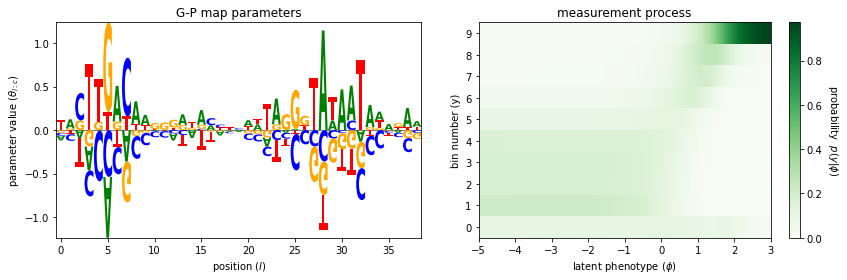

In [6]:
# Get G-P map parameters in matrix form
theta_df = model.get_gpmap_parameters(which="additive")

# Change theta_df to a matrix format compatible with logomaker
theta_logomaker_df = mavenn.tidy_df_to_logomaker_df(theta_df)

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Left panel: draw logo using logomaker
ax = axs[0]
logo = logomaker.Logo(theta_logomaker_df, ax=ax)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# Right panel: draw measurement process as heatmap
ax = axs[1]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('sortseq_mpa_visualization.png')
plt.show()